# Выбор региона для добычи нефти

На основе имеющихся данных о месторождениях в трех регионах необходимо выбрать наиболее прибыльное место добычи, с максимально возможным риском убытков.

Предоставлено 3 датасета, содержащие информацию о пробах нефти и запасах продуктов.  
Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Оптимальный регион выбирается с помощью bootstrap-а.

## Загрузка и подготовка данных

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

sns.set_color_codes('muted')
sns.set_style('ticks', {'axes.grid': 'True'})
mc = 'dodgerblue'
pd.options.mode.chained_assignment = None

Значение seed для параметра random_state:

In [2]:
SEED = 42

### Изучение общей информации о регионах:

Информация о регионах предоставлена в виде трех датасетов:

In [3]:
df_1 = pd.read_csv('/datasets/geo_data_0.csv')
df_2 = pd.read_csv('/datasets/geo_data_1.csv')
df_3 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
datas = {
    'df_1':df_1,
    'df_2':df_2,
    'df_3':df_1
}

datas_descr = {
    'df_1':'Регион добычи №1',
    'df_2':'Регион добычи №2',
    'df_3':'Регион добычи №3'
}

columns = list(df_1.columns)

cols_descr = {
    'f0':'Синтетический признак f0',
    'f1':'Синтетический признак f1',
    'f2':'Синтетический признак f2',
    'product':'Объем запасов, тыс. баррелей'
}

Выведем датасеты и посмотрим, что они содержат:

In [5]:
for df in datas.items():
    print(datas_descr[df[0]])
    display(df[1].head())

Регион добычи №1


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Регион добычи №2


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


Регион добычи №3


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


Всего в датафреймах 5 признаков: id, f0, f1,f2, product и по 100 000 строк в каждом.

Данные содержат следующую информацию:
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три синтетических признака точек;
* product — объём запасов в скважине (тыс. баррелей).

product - целевой признак, который представлен непрерывной переменной.

In [6]:
for df in datas.items():
    print(datas_descr[df[0]])
    print('Количество полных дубликатов:' ,df[1].duplicated().sum())
    print('_'*37)
    display(df[1].info())

Регион добычи №1
Количество полных дубликатов: 0
_____________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Регион добычи №2
Количество полных дубликатов: 0
_____________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Регион добычи №3
Количество полных дубликатов: 0
_____________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Во всех датафреймах одинаковое количество строк и столбцов, пропущенные значения отсутствуют. Сами данные имеют следующий тип:
id - тип данных object
f0, f1, f2, product - типы данных float

* Признаки имеют корректный тип данных, обработка не требуется.
* Пропущенных значений нет, обработка не требуется.
* Полные дубликаты отсутствуют.

Изучим основные стат. показатели и построим гистограммы:

In [7]:
def draw_hist(key):
    fig = plt.figure(figsize=(16,10))
    fig.suptitle(f'{datas_descr[key]} гистограммы', fontsize=16)
    
    ax_1 = fig.add_subplot(2,3,1)
    sns.histplot(x='f0', data=datas[key], kde=True, color='dodgerblue', bins=100)
    ax_1.set(ylabel='Количество наблюдений', xlabel=cols_descr['f0'])
    
    ax_2 = fig.add_subplot(2,3,2)
    sns.histplot(x='f1', data=datas[key], kde=True, color='dodgerblue', bins=100)
    ax_2.set(xlabel=cols_descr['f1'], ylabel='')
    
    ax_3 = fig.add_subplot(2,3,3)
    sns.histplot(x='f2', data=datas[key], kde=True, color='dodgerblue', bins=100)
    ax_3.set(xlabel=cols_descr['f2'], ylabel='')
    
    ax_4 = fig.add_subplot(2,1,2)
    sns.histplot(x='product', data=datas[key], kde=True, color='dodgerblue', bins=100)
    ax_4.set(ylabel='Количество наблюдений', xlabel=cols_descr['product'])

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


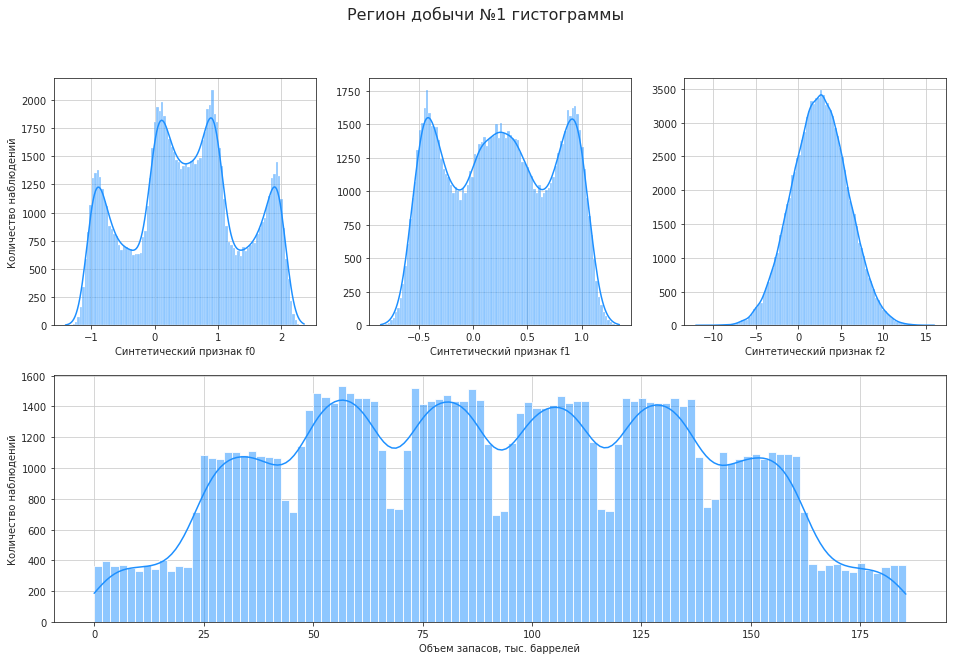

In [8]:
display(df_1.describe())
draw_hist('df_1')

Регион 1:  
* Распределение всех признаков непрерывное. Все признаки синтетические, из них f0, f1, product имеют необычное распределение с несколькими модами. Признак f2 имеет нормальное распредление.
* Среднее количество продукта в регионе: 92.5 тыс. баррелей
* Минимальное и максимальное количество продукта в регионе: 0 и 185.36 тыс. барреллей соответственно

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


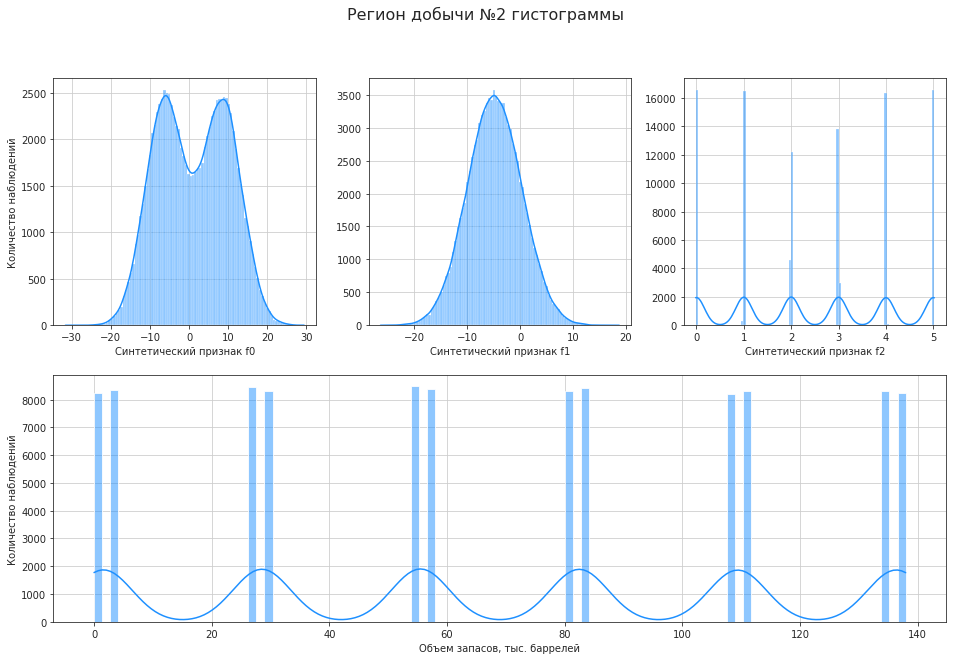

In [9]:
display(df_2.describe())
draw_hist('df_2')

Регион 2:  
* f0 распределение практически бимодальное, f1 - нормальное распределение, f2 и product - дискретное распределение
* Среднее количество продукта в регионе: 68.82 тыс. баррелей
* Минимальное и максимальное количество продукта в регионе: 0 и 137.9 тыс. барреллей соответственно

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


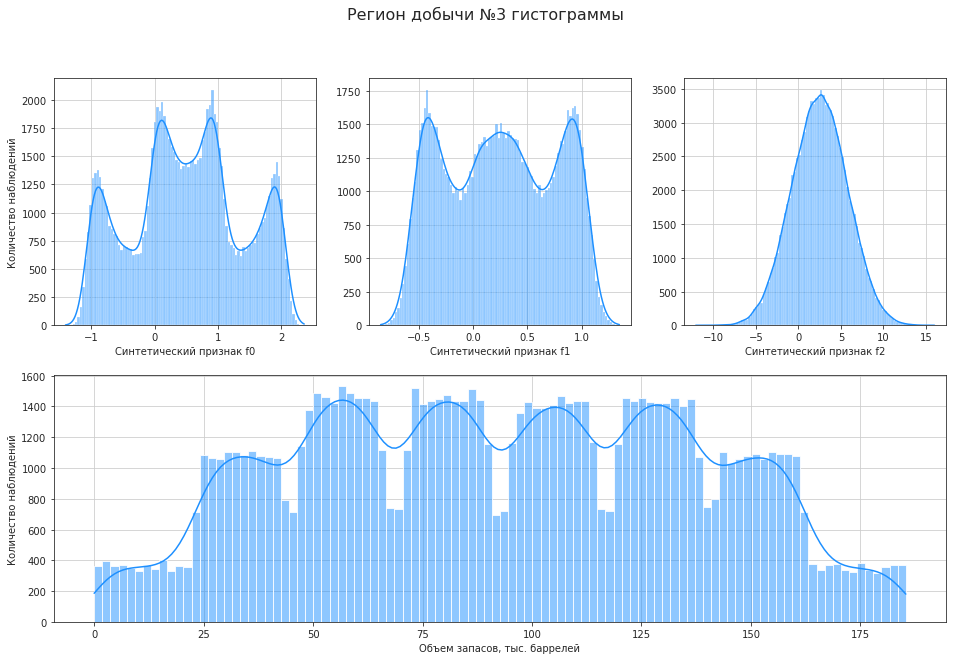

In [10]:
display(df_3.describe())
draw_hist('df_3')

Регион 3:  
* Регион очень похож на первый регион, выводы так же похожи
* Распределение всех признаков непрерывное. Все признаки синтетические, из них f0, f1, product имеют необычное распределение с несколькими модами. Признак f2 имеет нормальное распредление.
* Среднее количество продукта в регионе: 95 тыс. баррелей
* Минимальное и максимальное количество продукта в регионе: 0 и 190 тыс. барреллей соответственно

Проверим зависимости в данных:

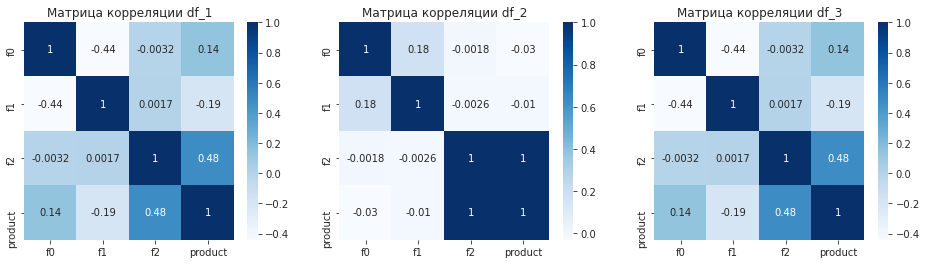

In [11]:
fig, axes = plt.subplots(1,3, figsize=(16,4))
for i, df in enumerate(datas.items()):
    plt.subplot(1,3,i+1)
    sns.heatmap(df[1].corr(), xticklabels=df[1].corr().columns, 
            yticklabels=df[1].corr().columns, cmap='Blues', annot=True)
    plt.title(f'Матрица корреляции {df[0]}')

В датасетах 1 и 3 присутствует средняя отрицательная корреляция между признаками f1 и f0, а так же средняя положительная корреляция между признаком f2 и целевым признаком product.

В датасете 2 линейная зависимость признака f2 и product. Ранее мы строили гистограммы для этих признаков, действительно распределения очень сильно похожи.

Признаки синтетические и важны для исследования и построения модели, удалять их, несмотря на сильную корреляцию, не будем.

### Вывод по этапу подготовки данных

Для расчета возможной прибыли и построения плана разработки месторождений нам предоставлено 3 датасета, содержащие информацию о скважинах в трех регионах. Каждый из датасетов содержит 100000 строк и 5 столбцов с различной информацией:
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три синтетических признака точек;
* product — объём запасов в скважине (тыс. баррелей).

При этом самые большие средние запасы нефти имеет регион 3, после него идет регион 1: 95 и 92 тыс. баррелей соответственно. Меньше всего запасы во 2 регионе: 68.8 тыс. баррелей.

Сами признаки в датасетах имеют разные распределения, но схожие средние значения. Заметна очень сильная корреляция признака f2 и product региона 2. Остальные признаки либо не имеют корреляции с другими признаками/целевым признаком, либо имеют незначительную/умеренную корреляцию.

## Обучение и проверка модели

### Обучение и подготовка модели

Подготовим и обучим модель линейной регрессии, получим предсказания и посчитаем метрики. Алгоритм такой:
1. Разобъем данные на признаки и целевую переменную, удалив лишнее
2. Разобъем признаки и целевую переменную на обучающую и валидационную выборку в отношении 3:1
3. Обучим модель, получим предсказания
4. Рассчитаем метрики

Реализуем для удобства все эти шаги в одной функции:

In [12]:
def train_linear_regression(df):
    X = df.drop(['id', 'product'], axis = 1)
    y = df['product']
    
    X_train, X_valid, y_train, y_valid = train_test_split(
                                    X, y, test_size=0.25, random_state=SEED)
    
    model = LinearRegression(n_jobs=-1)
    model.fit(X_train, y_train)
    
    pred = model.predict(X_valid)
    
    mse = mean_squared_error(y_valid, pred)
    rmse = mse ** 0.5
    
    pred = pd.Series(pred, X_valid.index)
    
    return pred, y_valid, mse, rmse, y_valid.mean(), pred.mean()

Результаты:

In [13]:
pred_product_reg_1, valid_reg_1, *scores_reg_1 = train_linear_regression(df_1)
pred_product_reg_2, valid_reg_2, *scores_reg_2 = train_linear_regression(df_2)
pred_product_reg_3, valid_reg_3, *scores_reg_3 = train_linear_regression(df_3)

Списки с предсказаниями и валидационной выборкой, для удобства:

In [14]:
pred_products = [pred_product_reg_1, pred_product_reg_2, pred_product_reg_3]
valid_products = [valid_reg_1, valid_reg_2, valid_reg_3]

Табличка с результатами:

In [15]:
total_regions = pd.DataFrame(index=['region_1', 'region_2', 'region_3'],
             columns=['MSE', 'RMSE', 'true_mean', 'predicted_mean'])

In [16]:
total_regions.loc['region_1'] = scores_reg_1
total_regions.loc['region_2'] = scores_reg_2
total_regions.loc['region_3'] = scores_reg_3

In [17]:
total_regions

,MSE,RMSE,true_mean,predicted_mean
region_1,1425.56087,37.7566,92.325956,92.3988
region_2,0.792599,0.89028,68.725381,68.712878
region_3,1611.691064,40.145872,95.150999,94.771024


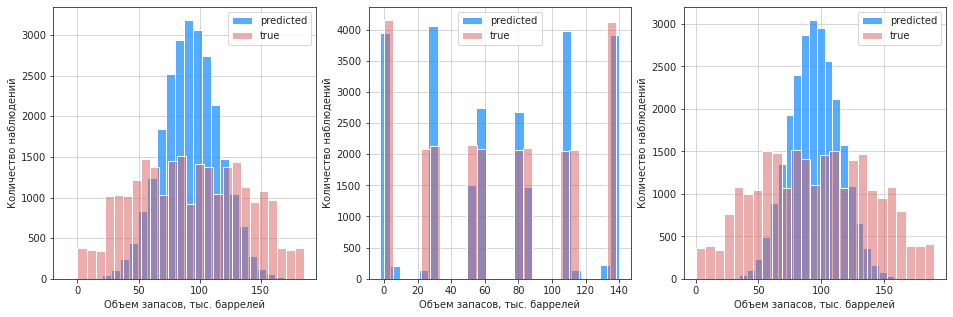

In [18]:
plt.subplots(1,3,figsize=(16,5))
for i, product in enumerate(zip(pred_products, valid_products)):
    plt.subplot(1,3,i+1)
    sns.histplot(product[0], color='dodgerblue', bins=25)
    sns.histplot(product[1], color='r', alpha=0.5, bins=25)
    plt.xlabel(cols_descr['product'])
    plt.ylabel('Количество наблюдений')
    plt.legend(['predicted','true'])

### Вывод

Мы обучили модель линейной регрессии для трех регионов, получили предсказания на валидационной выборке и вычислили метрики MSE, RMSE.  
Результаты:

In [19]:
total_regions

,MSE,RMSE,true_mean,predicted_mean
region_1,1425.56087,37.7566,92.325956,92.3988
region_2,0.792599,0.89028,68.725381,68.712878
region_3,1611.691064,40.145872,95.150999,94.771024


Лучше всего модель получилась для региона 2, ее MSE/RMSE практически равно нулю, она очень точно предсказывает значение продукта. Это объясняется тем, что между признаком обучающей выборки f2 и целевой переменной была линейная зависимость, а сами наблюдения в признаках дискретные, ошибиться модели тут очень сложно.

Другая ситуация с регионами 1 и 3, RMSE = 37 и 40 соответственно, предсказания модели не совсем точные, но если взять результат предсказания в среднем, он практически совпадает с реальным значением.

## Подготовка к расчёту прибыли

Зададим переменные для расчета прибыли:
* Бюджет на разработку скважин в одном регионе: 10 млрд. руб.
* Доход с каждой единицы продукта: 450 тыс. руб.

По условию задания из исследуемых 500 месторождений отбирается 200 лучших, которые в дальнейшем будут осваиваться.
* Количество исследуемых месторождений: 500 единиц
* Количество лучших месторождений для освоения: 200 единиц

In [20]:
BUDGET_TOTAL = 10**10
INCOME_PER_BARILE = 450000
N_FIELD = 500
N_BEST_FIELD = 200

Вычислим, какой бюджет предполагается на разработку одного месторождения, разделим общий бюджет на количество лучших месторождений.

In [21]:
BUDGET_PER_FIELD = BUDGET_TOTAL / N_BEST_FIELD
BUDGET_PER_FIELD

50000000.0

Точка безубыточности месторождения определяется, как отношение бюджета на одно месторождение к предполагаемой прибыли с единицы продукта:

In [22]:
THRESHOLD = BUDGET_PER_FIELD / INCOME_PER_BARILE
THRESHOLD

111.11111111111111

Получается, что месторождение перестает быть убыточным только в том случае, если в нем содержится более 111 тыс. единиц продукта.

Ранее мы вычислили средние значения в валидационной выборке, они были равны: 92, 68, 95 тыс. баррелей для каждого из регионов. Легко заметить, что в среднем в регионах не хватает нефти, необходимо дальнейшее исследование, получится ли выбрать наиболее рентабельные месторождения.

Чтобы это выяснить проведем бутстреп данных, получим изначальную популяцию, рассчитаем прибыльность регионов и риски убытков.

## Расчёт прибыли и рисков 

Ранее мы упоминали, что по условию задания из исследуемых 500 месторождений отбирается 200 лучших, которые в дальнейшем будут осваиваться.
* Количество исследуемых месторождений: 500 единиц
* Количество лучших месторождений для освоения: 200 единиц

Реализуем расчет прибыли с помощью бутстрепа, будем случайным образом выбирать 500 месторождений из предсказанных значений, затем из них отбирать 200 лучших (имеющих наибольшие запасы продукта) и рассчитывать прибыль для региона.

Глобальные переменные для дальнейших расчетов:
1. Параметр state для аргумента random_state, позволит выполнить бутстреп без постоянного повторения одинакового результата
2. Количество итераций бутстрепа
3. Нижняя и верхняя граница доверительного результата для прибыли

In [23]:
state = np.random.RandomState(SEED)
BOOTSRAP_N = 1000
q_lower = 0.025
q_upper = 0.975

Функции для облегчения рассчетов:
1. income_per_region принимает на вход выборку, сортирует по количеству продукта, отбирает 200 лучших месторождений, суммирует все значения продукта, считает прибыль.
2. bootstrap_income, принимает на вход выборку, бутстрапирует ее и с помощью функции income_per_region считает прибыль
3. results_calculation - считает нижний, верхний квантиль и среднее по прибыли

In [24]:
def income_per_region(pred, valid):
    '''Функция рассчитывает прибыль в регионе. Возвращает значение прибыли'''
    best_fields = (
        pred
        .sort_values(ascending=False)
        .head(N_BEST_FIELD)
    )
    total_product_best_fields = valid[best_fields.index].sum()
    
    
    income = (total_product_best_fields * INCOME_PER_BARILE) - BUDGET_TOTAL
    return income

def bootstrap_income(pred, valid):
    '''Функция бутстрапирует переданную в нее выборку и на основе ее рассчитывает прибыль в регионе, а так же риск убытка
       Возвращает Series со значением прибыли и значение риска убытка'''
    incomes_lst = []
    for i in range(BOOTSRAP_N):
        subsample = pred.sample(n=N_FIELD, replace=True, random_state=state)
        inc = income_per_region(subsample, valid)
        incomes_lst.append(inc)
        
    
    incomes_series = pd.Series(incomes_lst)
    loss = (incomes_series < 0).mean()
    
    return incomes_series, loss



def results_calculation(income):
    '''Функция рассчитывает нижний, верхний квантиль и среднее для выборки. Функция возвращает список рассчитанных значений'''
    lower = income.quantile(q_lower)
    upper = income.quantile(q_upper)
    mean = income.mean()
    
    return [lower, upper, mean]

Применим функции на предсказанные значения:

In [25]:
incomes = []
results = []
for prod in zip(pred_products, valid_products):
    bootstrap_res = bootstrap_income(prod[0], prod[1])
    income = bootstrap_res[0]
    result = [bootstrap_res[1]] + results_calculation(income)
    

    incomes.append(income)
    results.append(result)
total_regions.loc[:, ['loss', 'lower_q', 'upper_q', 'income_mean']] = results

Построение 95% доверительного интервала для данных полученных бутстрепом:

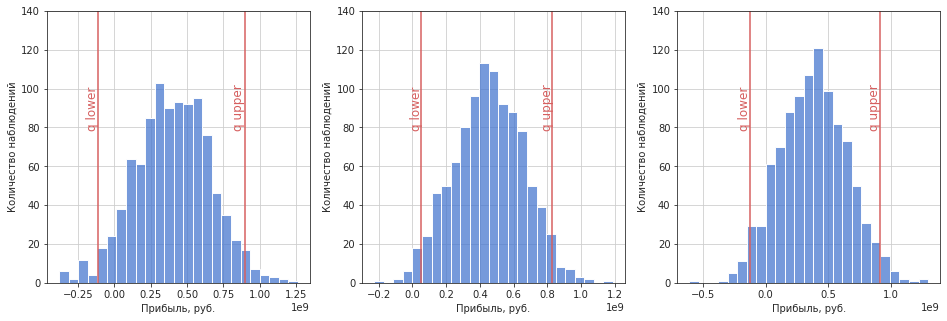

In [26]:
plt.subplots(1,3,figsize=(16,5))
for i, res in enumerate(zip(incomes, results)):
    plt.subplot(1,3, i+1)
    sns.histplot(res[0], bins=25, color='b')
    plt.axvline(x = res[1][1], color = 'r')
    plt.axvline(x = res[1][2], color = 'r')
    plt.text(x = res[1][1] - np.std(res[0])/3, y = 80, s='q lower', rotation=90, color='r', fontsize=12)
    plt.text(x = res[1][2] - np.std(res[0])/3, y = 80, s='q upper', rotation=90, color='r', fontsize=12)
    plt.ylim(0,140)
    plt.ylabel('Количество наблюдений')
    plt.xlabel('Прибыль, руб.')

Не все доверительные интервалы получились положительными, только регион 2 находится имеет 95% значений в положительном участке

Результаты представлены в таблице, lower_q и upper_q - квантили 95% доверительного интервала; loss - риск убытка, %; income_mean - средняя прибыль по региону.

In [27]:
total_regions

,MSE,RMSE,true_mean,predicted_mean,loss,lower_q,upper_q,income_mean
region_1,1425.56087,37.7566,92.325956,92.3988,0.060,-1.104679e+08,8.974603e+08,3.995755e+08
region_2,0.792599,0.89028,68.725381,68.712878,0.009,5.230941e+07,8.301463e+08,4.525766e+08
region_3,1611.691064,40.145872,95.150999,94.771024,0.075,-1.277794e+08,9.079235e+08,3.787059e+08


Единственный регион, в котором вероятность убытка менее 2.5% - регион №2. Вероятность убытка в нем составляет 0.9%, а средняя прибыль равна 452 млн. руб. Конечный выбор региона для освоения падает именно на него.

В регионах 1 и 3 вероятность убытка составила 6% и 7.5%, что значительно выше порога, придется отказаться от разработки этих регионов.

## Вывод по проекту

In [28]:
total_regions

,MSE,RMSE,true_mean,predicted_mean,loss,lower_q,upper_q,income_mean
region_1,1425.56087,37.7566,92.325956,92.3988,0.060,-1.104679e+08,8.974603e+08,3.995755e+08
region_2,0.792599,0.89028,68.725381,68.712878,0.009,5.230941e+07,8.301463e+08,4.525766e+08
region_3,1611.691064,40.145872,95.150999,94.771024,0.075,-1.277794e+08,9.079235e+08,3.787059e+08


1. Для расчета возможной прибыли и построения плана разработки месторождений нам было предоставлено 3 датасета, содержащие информацию о скважинах в трех регионах. Каждый из датасетов содержит 100000 строк и 5 столбцов с различной информацией:
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три синтетических признака точек;
* product — объём запасов в скважине (тыс. баррелей).

При этом самые большие средние запасы нефти имеет регион 3, после него идет регион 1: 95 и 92 тыс. баррелей соответственно. Меньше всего запасы во 2 регионе: 68.8 тыс. баррелей.

Сами признаки в датасетах имеют разные распределения, но схожие средние значения. Заметна очень сильная корреляция признака f2 и product региона 2. Остальные признаки либо не имеют корреляции с другими признаками/целевым признаком, либо имеют незначительную/умеренную корреляцию. Дополнительная обработка данных перед моделированием не требовалась.

2. Мы разбили наши данные на обучающую и валидационные выборки в отношении 3:1 и произвели обучение и предсказание результатов для каждого из регионов, а так же вычислили основные метрики MSE, RMSE и средние показатели продукта

Регион 1 и регион 3 имеют близкое среднее значение продукта - 92-95 тыс. баррелей, а регион 1 имеет самое низкое среднее количество продукта - 69 тыс. баррелей.

В таблице представлены значения метрик и средних:
* Модель региона 1 имеет средние показатели, по сравнению с остальными: MSE=1404; RMSE=37.5
* Модель региона 2 получилась самой точной, она имеет очень низкие MSE и RMSE (меньше единицы)
* Модель региона 3 имеет самую низкую точность из всех, MSE=1602, RMSE=40

Получается, что для регионов 1 и 3 мы имеем низкую точность (При RMSE=37/40 и среднем 92/95 ошибка получается порядка 35-40%).

Хорошие показатели модели для региона 2 скорее всего обусловлены изначальным распределением признаков и продукта (сама задача практически сводится к классификации), а так же наличии очень сильной корреляции между признаком f2 и целевым признаком в данном датасете.

3. Вычислив значения запасов сырья в скважинах мы произвели подготовку к расчету прибыли: вычислили необходимый порог для разработки одной скважины и задали основные константы. Так же определили функцию для расчета прибыли от 200 лучших скважин.

Для получения общего представления о прибыли мы воспользовались методом bootstrap на 1000 выборках для 500 точек, каждый раз отбирая 200 лучших скважин и вычисляя для них прибыль. Так же мы подсчитали вероятность риска, в случаях, когда прибыль становилась отрицательной.

**В результате единственным регионом с риском убытка менее 2.5% оказался регион №2. Средняя прибыль в нем на основе бутстрепа - 452 млн. руб, риск убытка 0.9%.**